# Example: 1D Gaussian Mixture

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## GMM model

I'll adopt a 3-component 1D Gaussian mixture model. Below I'll define a function which evaluates the PDF as a function of $x$. The means / widths / weights of the three Gaussian components are stored in the arrays `mu`, `sig` and `w` respectively.

In [4]:
def gmm_pdf(x):
    mu = np.array([-3.0, 0.5, 2.5])
    sig = np.array([1.0, 0.25, 0.75])
    w = np.array([0.4, 0.25, 0.35])
    return np.sum([w[i] * norm.pdf(x, mu[i], sig[i]) for i in range(3)], axis=0)


Let's visualise the PDF:

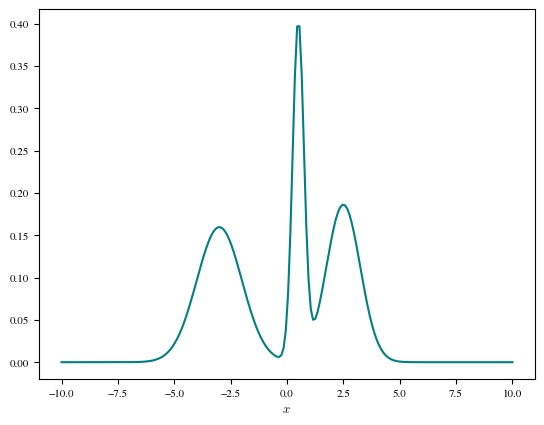

In [5]:
x = np.linspace(-10, 10, 200)
plt.plot(x, gmm_pdf(x), c='teal')
plt.xlabel('$x$', usetex=True);

## `gridsample`: fixed grid

Here we'll take a fixed grid with 32 cells from $x=-10$ to $x=10$, and use `gridsample` to draw a million samples. First import `gridsample`:

In [6]:
from gridsample import gridsample

Set up the grid, and evaluate the PDF at the grid edges (note that the grid has 32 cells, so 33 edges):

In [7]:
N_cells = 32
x_min = -10
x_max = 10
x_edges = np.linspace(x_min, x_max, N_cells + 1)
f = gmm_pdf(x_edges)

Draw samples:

In [8]:
samples = gridsample(x_edges, f=f, N_samples=1000000)

Now we can visualise the samples, and compare with the true PDF.

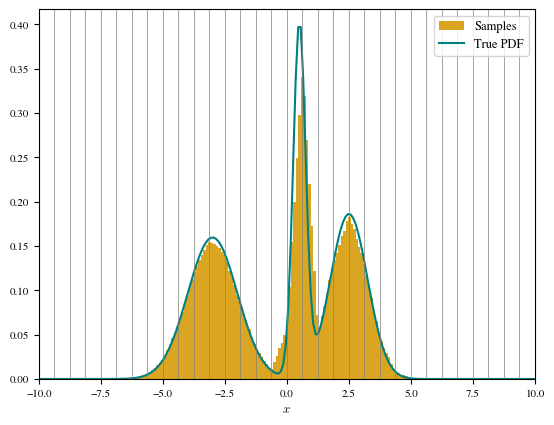

In [9]:
bins = np.linspace(-10, 10, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-10, 10)
ylim = plt.gca().get_ylim()
for edge in x_edges:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

This does a pretty good job! Could be better, particularly close to the Gaussian peaks. The problem here is insufficient grid resolution. One could either increase the number of grid cells, or adopt a variable grid with more resolution where needed. We'll try the latter.

## `gridsample`: Variable grid

Now we can set up a variable grid, again with 32 cells, but now with more resolution in the relevant regions and less resolution elsewhere. Here I just hard-code the array of edges, but of course one could imagine doing something smarter.

In [10]:
x_edges = np.hstack([
    np.linspace(-10, -5, 4, endpoint=False),
    np.linspace(-5, -0, 8, endpoint=False),
    np.linspace(0, 5, 16, endpoint=False),
    np.linspace(5, 10, 5, endpoint=True),
])
f = gmm_pdf(x_edges)

Draw samples:

In [11]:
samples = gridsample(x_edges, f=f, N_samples=1000000)

Visualise:

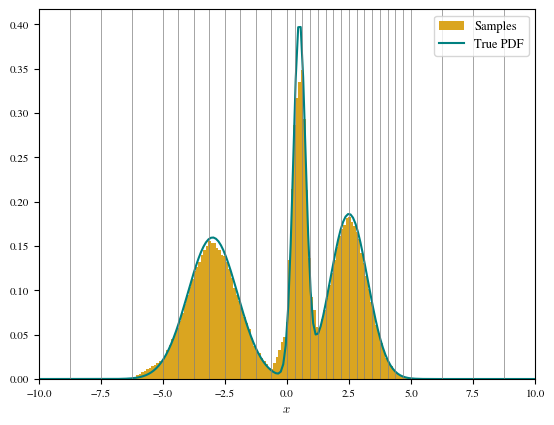

In [12]:
bins = np.linspace(-10, 10, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-10, 10)
ylim = plt.gca().get_ylim()
for edge in x_edges:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

That's better!

## `sample`

Another way to do the above is via the function `sample`, which does not assume that the input densities are evaluated on a grid. One instead provides the first and last coordinates of an arbitrary series of cells, as well as a series of arrays giving the corner densities of the same cells. We'll just reuse the cells from the same grid above, but in principle we could do anything, e.g. multiple disconnected groups of cells. First we'll import `sample`: 

In [13]:
from gridsample import sample

Now let's get the cell coordinates and densities. Note that `sample` expects the coordinate arrays `x0`/`x1` to either be 1D (length $k$) representing a single $k$-dimensional cell, or 2D (shape $N\times k$) representing a batch of $N$ cells. In our case, we have a batch of 1D cells so we shape the coordinate arrays as 2D arrays, shaped ($N \times 1$).

In [14]:
f0 = f[:-1]
f1 = f[1:]
x0 = x_edges[:-1][:, None]
x1 = x_edges[1:][:, None]

Draw samples:

In [15]:
samples = sample(x0, x1, f0, f1, N_samples=100000)

Visualise:

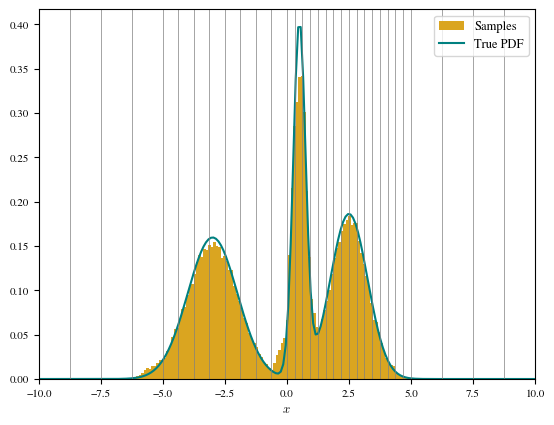

In [16]:
bins = np.linspace(-10, 10, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-10, 10)
ylim = plt.gca().get_ylim()
for edge in x_edges:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

Which is a very similar result to last time. The interface of `sample` is a little more complicated than `gridsample` as a result of its increased flexibility. This might not seem worth it here, but the power of `sample` is more apparent in situations where we need to go beyond a single regular grid. We'll see more of that in other examples. 

## Final checks

Let's just check that we do get near-perfect results if we increase the number of grid cells a lot. Here is outcome of a fixed grid with 512 cells:

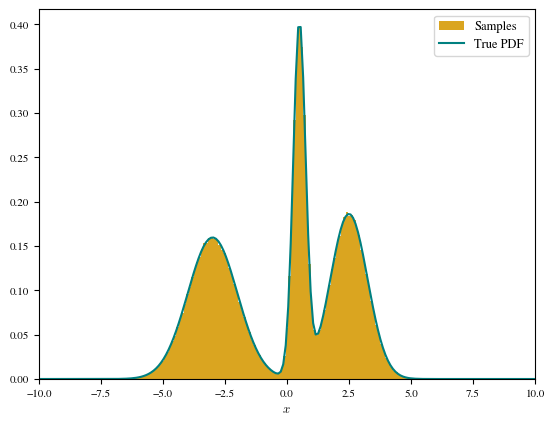

In [17]:
N_cells = 512
x_min = -10
x_max = 10
x_edges = np.linspace(x_min, x_max, N_cells + 1)
f = gmm_pdf(x_edges)

samples = gridsample(x_edges, f=f, N_samples=1000000)
bins = np.linspace(-10, 10, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-10, 10);

Just for fun, we can take the samples and fit a Gaussian mixture model just to check that we get results that roughly match the 'truths'.

In [18]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3).fit(samples[:, None])
order = np.argsort(gm.means_.squeeze())
print(f"Fitted means:\n {gm.means_[order].squeeze()}")
print(f"True means:\n {[-3.0, 0.5, 2.5]}\n")

print(f"Fitted widths:\n {np.sqrt(gm.covariances_[order]).squeeze()}")
print(f"True widths:\n {[1.0, 0.25, 0.75]}\n")

print(f"Fitted weights:\n {gm.weights_[order]}")
print(f"True weights:\n {[0.4, 0.25, 0.35]}\n")

Fitted means:
 [-3.00122721  0.50479817  2.51665652]
True means:
 [-3.0, 0.5, 2.5]

Fitted widths:
 [0.99953049 0.25641271 0.73712326]
True widths:
 [1.0, 0.25, 0.75]

Fitted weights:
 [0.39878116 0.25348822 0.34773062]
True weights:
 [0.4, 0.25, 0.35]



So, the fitted GMM parameters very closely match the truths.